In [3]:
%matplotlib inline

#### Requirements



1.   Connect colab to your google drive
2.   Navigate into the folder where the unet is stored



In [4]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [5]:
import sys
sys.path.insert(0, '/gdrive/MyDrive/unet-nested-multiple-classification')

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import argparse
import logging
import os
import os.path as osp
from PIL import Image

# Change this path to wherever you installed the Pytorch-UNet module
#sys.path.append('C:/Users/Groh/Documents/GitHub/unet-nested-multiple-classification')
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from unet import NestedUNet
from unet import UNet
from utils.dataset import BasicDataset
from config import UNetConfig

from losses import LovaszLossSoftmax
from losses import LovaszLossHinge
from losses import dice_coeff

import cv2
! pip install albumentations==0.4.6
import albumentations as A
import albumentations.augmentations.functional as Fu
from albumentations.pytorch.transforms import ToTensorV2
import copy

from os.path import splitext
from os import listdir

from glob import glob

from torchvision.transforms import functional as func
from numpy import moveaxis
import matplotlib.pyplot as plt





#### Assing absolute paths of image and mask folders

In [7]:
# Change this path to the respective image and mask folders

dir_img = '../gdrive/MyDrive/unet-nested-multiple-classification/data/images/'
dir_mask = '../gdrive/MyDrive/unet-nested-multiple-classification/data/masks/'
dir_checkpoint = '../gdrive/MyDrive/unet-nested-multiple-classification/data/checkpoints/'

#print(dir_img)
#print(dir_mask)
#print(dir_checkpoint)

images_filenames = list(sorted(os.listdir(dir_img)))
images_filenames = images_filenames[:-1]
print(images_filenames)

#dir_img = 'C:/Users/Groh/Documents/GitHub/unet-nested-multiple-classification/data/images/'
#print(dir_img)
#dir_mask = 'C:/Users/Groh/Documents/GitHub/unet-nested-multiple-classification/data/masks/'
#dir_checkpoint = 'C:/Users/Groh/Documents/GitHub/unet-nested-multiple-classification/data/checkpoints/'

['aicm05_02_000017.png', 'aicm05_02_000018.png', 'aicm05_02_000021.png', 'aicm05_02_000022.png', 'aicm05_02_000023.png', 'aicm05_02_000024.png', 'aicm05_02_000025.png', 'aicm05_02_000026.png', 'aicm05_02_000027.png', 'aicm05_02_000043.png', 'aicm05_02_000044.png', 'aicm05_02_000045.png', 'aicm05_02_000046.png', 'aicm05_02_000052.png', 'aicm05_02_000053.png', 'aicm05_02_000054.png', 'aicm05_02_000055.png', 'aicm05_02_000065.png', 'aicm05_02_000066.png', 'aicm05_02_000069.png', 'aicm05_02_000070.png', 'aicm05_02_000071.png', 'aicm05_02_000072.png', 'aicm05_02_000073.png', 'aicm05_02_000094.png', 'aicm05_02_000095.png', 'aicm05_02_000096.png', 'aicm05_02_000097.png', 'aicm05_02_000098.png', 'aicm05_02_000099.png', 'aicm05_02_000109.png', 'aicm05_02_000110.png', 'aicm05_02_000112.png', 'aicm05_02_000113.png', 'aicm05_02_000114.png', 'aicm05_02_000115.png', 'aicm05_02_000116.png', 'aicm05_02_000121.png', 'aicm05_02_000122.png', 'aicm05_02_000125.png', 'aicm05_02_000126.png', 'aicm05_02_0001

#### Prepare masks for multi instance segmentation

In [16]:
convert_files = False

In [17]:
num_files = len([f for f in os.listdir(dir_img)if os.path.isfile(os.path.join(dir_img, f))])

if convert_files:
    for i in range(num_files):
        name = os.listdir(dir_img)[i]
        file = dir_mask+name

        # If a mask is missing, create a new, empty mask
        if not os.path.isfile(file):
            img = Image.open(dir_img+name)
            width, height = img.size

            img_new = Image.new('L', (width, height))
            img_new.save(file, "PNG")

        # Convert all images to 8-bit gray scales
        img_grayscale = Image.open(file).convert('L')
        img_grayscale.save(file)


        # Check, whether more than background is visible in the mask
        image_gray = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        unique = np.unique(image_gray.flatten())
        if len(unique) > 1:
            # For every pixel change gray-scale value according to categorical value
            img = Image.open(file)
            # Create pixel map
            pixels = img.load()
            for ii in range(img.size[0]): 
                for j in range(img.size[1]):
                    if pixels[ii,j] == 52: # Atraum. Pinzette
                        pixels[ii,j] = 1
                    elif pixels[ii,j] == 113: # Nadelhalter
                        pixels[ii,j] = 2
    #                     elif pixels[i,j] = 52:
    #                         pixels[i,j] = 1
    #                     elif pixels[i,j] = 52:
    #                         pixels[i,j] = 1
    #                     elif pixels[i,j] = 52:
    #                         pixels[i,j] = 1
    #                     elif pixels[i,j] = 52:
    #                         pixels[i,j] = 1
    #                     elif pixels[i,j] = 52:
    #                         pixels[i,j] = 1
            img.save(file)

## Data Augmentation

In [8]:
#erstellt Dataset mit Trainingsbildern und -masken
class TrainingDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        pathImage = os.path.join(self.images_directory, image_filename)
        pathMask = os.path.join(self.masks_directory, image_filename)
        #print(pathImage)
        pillow_image = Image.open(pathImage)
        image = np.array(pillow_image)
        pillow_mask = Image.open(pathMask)
        mask = np.array(pillow_mask)
        
        if self.transform is not None:
          transformed = self.transform(image=image, mask=mask)
          image = transformed["image"]
          mask = transformed["mask"]
          image_np = np.array(image)
          mask_np = np.array(mask)
         
          #to get channels_first format
          #image_np = moveaxis(image_np, 2,0)
                    
          image = func.to_tensor(np.array(image_np))
          mask = func.to_tensor(np.array(mask_np)) 

          #image_tensor = torch.from_numpy(image_np).type(torch.FloatTensor)
          #mask_tensor = torch.from_numpy(mask_np).type(torch.FloatTensor)

        return {
            'image': image,
            'mask':  mask
        }          
        
#tatsächliche Augmentation
#möglicherweise noch andere Transformationen einfügen

train_transform = A.Compose([
    A.HorizontalFlip(p=1),
    A.Rotate (limit=[-10, 10]),
    A.Blur (blur_limit=4, always_apply=False, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
    #A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
    #A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
])

train_dataset = TrainingDataset(images_filenames, dir_img, dir_mask, train_transform)
#train_dataset.__getitem__(5)




Visualization of different augmentations applied to the same image and the associated mask

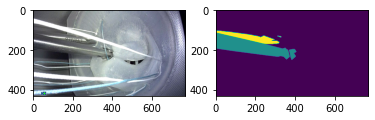

In [17]:
def visualize(dataset):
  index = np.random.choice(train_dataset.__len__(), 1)
  dictionary = dataset.__getitem__(index[0])
  dictionary2 = dataset.__getitem__(index[0])
  #print(type(dictionary))

  image, mask = dictionary["image"], dictionary["mask"]
  image = image.numpy().transpose((1,2,0))
  mask = mask.numpy().transpose((1,2,0))
 
  image2, mask2 = dictionary2["image"], dictionary2["mask"]
  image2 = image2.numpy().transpose((1,2,0))
  mask2 = mask2.numpy().transpose((1,2,0))
 
  plt.subplot(1, 2, 1) 
  plt.imshow(image)

  plt.subplot(1, 2, 2) 
  plt.imshow(np.squeeze(mask))  # zero'th channel is the background, 1st channel is the foreground or gauss points

  plt.subplot(2, 2, 1) 
  plt.imshow(image2)

  plt.subplot(2, 2, 2) 
  plt.imshow(np.squeeze(mask2))

visualize(train_dataset)

#### Train network

In [20]:
# Change UNet configuration if necessary
# Also important to change n_channels and n_classes
cfg = UNetConfig()

# Training function
def train_net(net, cfg):
    val_percent = cfg.validation / 100
    n_val = int(len(train_dataset) * val_percent)
    n_train = len(train_dataset) - n_val
       
    train, val = random_split(train_dataset, [n_train, n_val])
   
    train_loader = DataLoader(train,
                              batch_size=cfg.batch_size,
                              shuffle=True,
                              num_workers=8,
                              pin_memory=True)
    val_loader = DataLoader(val,
                            batch_size=cfg.batch_size,
                            shuffle=False,
                            num_workers=8,
                            pin_memory=True)

    writer = SummaryWriter(comment=f'LR_{cfg.lr}_BS_{cfg.batch_size}_SCALE_{cfg.scale}')
    global_step = 0

    logging.info(f'''Starting training:
        Epochs:          {cfg.epochs}
        Batch size:      {cfg.batch_size}
        Learning rate:   {cfg.lr}
        Optimizer:       {cfg.optimizer}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {cfg.save_cp}
        Device:          {device.type}
        Images scaling:  {cfg.scale}
    ''')

    if cfg.optimizer == 'Adam':
        optimizer = optim.Adam(net.parameters(),
                               lr=cfg.lr)
    elif cfg.optimizer == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(),
                                  lr=cfg.lr,
                                  weight_decay=cfg.weight_decay)
    else:
        optimizer = optim.SGD(net.parameters(),
                              lr=cfg.lr,
                              momentum=cfg.momentum,
                              weight_decay=cfg.weight_decay,
                              nesterov=cfg.nesterov)

    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=cfg.lr_decay_milestones,
                                               gamma = cfg.lr_decay_gamma)
    if cfg.n_classes > 1:
        criterion = LovaszLossSoftmax()
    else:
        criterion = LovaszLossHinge()

    for epoch in range(cfg.epochs):
        net.train()

        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{cfg.epochs}', unit='img') as pbar:
            for batch in train_loader:
                batch_imgs = batch['image']
                batch_masks = batch['mask']
                assert batch_imgs.shape[1] == cfg.n_channels, \
                        f'Network has been defined with {cfg.n_channels} input channels, ' \
                        f'but loaded images have {batch_imgs.shape[1]} channels. Please check that ' \
                        'the images are loaded correctly.'

                batch_imgs = batch_imgs.to(device=device, dtype=torch.float32)
                mask_type = torch.float32 if cfg.n_classes == 1 else torch.long
                batch_masks = batch_masks.to(device=device, dtype=mask_type)

                inference_masks = net(batch_imgs)

                #vergleich generierte masken mit ground truth masken
                if cfg.n_classes == 1:
                    inferences = inference_masks.squeeze(1)
                    masks = batch_masks.squeeze(1)
                else:
                    inferences = inference_masks
                    masks = batch_masks

                if cfg.deepsupervision:
                    loss = 0
                    for inference_mask in inferences:
                        loss += criterion(inference_mask, masks)
                    loss /= len(inferences)
                else:
                    loss = criterion(inferences, masks)

                epoch_loss += loss.item()
                writer.add_scalar('Loss/train', loss.item(), global_step)
                writer.add_scalar('model/lr', optimizer.param_groups[0]['lr'], global_step)

                pbar.set_postfix(**{'loss (batch)': loss.item()})

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

                pbar.update(batch_imgs.shape[0])
                global_step += 1

                if global_step % (len(train_dataset) // (1 * cfg.batch_size)) == 0:
                    val_score = eval_net(net, val_loader, device, n_val, cfg)
                    if cfg.n_classes > 1:
                        logging.info('Validation cross entropy: {}'.format(val_score))
                        writer.add_scalar('CrossEntropy/test', val_score, global_step)
                    else:
                        logging.info('Validation Dice Coeff: {}'.format(val_score))
                        writer.add_scalar('Dice/test', val_score, global_step)

                    writer.add_images('images', batch_imgs, global_step)
                    if cfg.deepsupervision:
                            inference_masks = inference_masks[-1]
                    if cfg.n_classes == 1:
                        # writer.add_images('masks/true', batch_masks, global_step)
                        inference_mask = torch.sigmoid(inference_masks) > cfg.out_threshold
                        writer.add_images('masks/inference',
                                          inference_mask,
                                          global_step)
                    else:
                        # writer.add_images('masks/true', batch_masks, global_step)
                        ids = inference_masks.shape[1]  # N x C x H x W
                        inference_masks = torch.chunk(inference_masks, ids, dim=1)
                        for idx in range(0, len(inference_masks)):
                            inference_mask = torch.sigmoid(inference_masks[idx]) > cfg.out_threshold
                            writer.add_images('masks/inference_'+str(idx),
                                              inference_mask,
                                              global_step)

        if cfg.save_cp:
            try:
                os.mkdir(cfg.checkpoints_dir)
                logging.info('Created checkpoint directory')
            except OSError:
                pass

            ckpt_name = 'epoch_' + str(epoch + 1) + '.pth'
            torch.save(net.state_dict(),
                       osp.join(cfg.checkpoints_dir, ckpt_name))
            logging.info(f'Checkpoint {epoch + 1} saved !')

    writer.close()
    

# Evaluation function
def eval_net(net, loader, device, n_val, cfg):
    """
    Evaluation without the densecrf with the dice coefficient

    """
    net.eval()
    tot = 0

    with tqdm(total=n_val, desc='Validation round', unit='img', leave=False) as pbar:
        for batch in loader:
            imgs = batch['image']
            true_masks = batch['mask']

            imgs = imgs.to(device=device, dtype=torch.float32)
            mask_type = torch.float32 if cfg.n_classes == 1 else torch.long
            true_masks = true_masks.to(device=device, dtype=mask_type)

            # compute loss
            if cfg.deepsupervision:
                masks_preds = net(imgs)
                loss = 0
                for masks_pred in masks_preds:
                    tot_cross_entropy = 0
                    for true_mask, pred in zip(true_masks, masks_pred):
                        pred = (pred > cfg.out_threshold).float()
                        if cfg.n_classes > 1:
                            sub_cross_entropy = F.cross_entropy(pred.unsqueeze(dim=0), true_mask.unsqueeze(dim=0).squeeze(1)).item()
                        else:
                            sub_cross_entropy = dice_coeff(pred, true_mask.squeeze(dim=1)).item()
                        tot_cross_entropy += sub_cross_entropy
                    tot_cross_entropy = tot_cross_entropy / len(masks_preds)
                    tot += tot_cross_entropy
            else:
                masks_pred = net(imgs)
                for true_mask, pred in zip(true_masks, masks_pred):
                    pred = (pred > cfg.out_threshold).float()
                    if cfg.n_classes > 1:
                        tot += F.cross_entropy(pred.unsqueeze(dim=0), true_mask.unsqueeze(dim=0).squeeze(1)).item()
                    else:
                        tot += dice_coeff(pred, true_mask.squeeze(dim=1)).item()

            pbar.update(imgs.shape[0])

    return tot / n_val


#### Configure training parameters and device

In [21]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Automatically uses a GPU, if it is available to torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
logging.info(f'Using device {device}')

net = eval(cfg.model)(cfg)
logging.info(f'Network:\n'
             f'\t{cfg.model} model\n'
             f'\t{cfg.n_channels} input channels\n'
             f'\t{cfg.n_classes} output channels (classes)\n'
             f'\t{"Bilinear" if cfg.bilinear else "Dilated conv"} upscaling')

if cfg.load:
    net.load_state_dict(
        torch.load(cfg.load, map_location=device)
    )
    logging.info(f'Model loaded from {cfg.load}')

net.to(device=device);
# faster convolutions, but more memory
# cudnn.benchmark = True

INFO: Using device cpu
INFO: Network:
	NestedUNet model
	3 input channels
	3 output channels (classes)
	Bilinear upscaling


#### Call the training function

In [ ]:
try:
    train_net(net=net, cfg=cfg)
except KeyboardInterrupt:
    
    torch.save(net.state_dict(), 'INTERRUPTED.pth')
    logging.info('Saved interrupt')
    try:
        sys.exit(0)
    except SystemExit:
        os._exit(0)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
INFO: Starting training:
        Epochs:          2
        Batch size:      2
        Learning rate:   0.0001
        Optimizer:       SGD
        Training size:   330
        Validation size: 36
        Checkpoints:     True
        Device:          cpu
        Images scaling:  1
    
Epoch 1/2:   0%|          | 0/330 [00:00<?, ?img/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, w